In [3]:
import pandas as pd
import matplotlib
import numpy as np 

import pandas as pd
import matplotlib
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import warnings, gc
warnings.filterwarnings('ignore')
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
data = pd.read_csv("Final_Data.csv.xls")
df = pd.DataFrame(data)
#df=df[0:99729]
print("Number of rows and columns are:")
df.shape

Number of rows and columns are:


(99730, 86)

In [5]:
df=df[0:99729]
from sklearn.model_selection import train_test_split

In [6]:
y = df["target"]
del df["target"]
X_train, X_test,y_train, y_test = train_test_split(df,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   )

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

In [7]:
ids=X_train["Customer_id"]
ids2=X_test["Customer_id"]
del X_train["Customer_id"]
del X_test["Customer_id"]

In [8]:
dt=DecisionTreeClassifier(max_depth=9)
dt.fit(X_train,y_train)

y_pred=dt.predict(X_test)
print("Decision Tree",end=" ")
print(accuracy_score(y_pred,y_test))

Decision Tree 0.8494936328085831


In [9]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))

Accuracy: 0.849
Precision: 0.693
Recall: 0.694
F1: 0.694


In [10]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_


Fitting 3 folds for each of 294 candidates, totalling 882 fits


DecisionTreeClassifier(max_leaf_nodes=52, random_state=42)

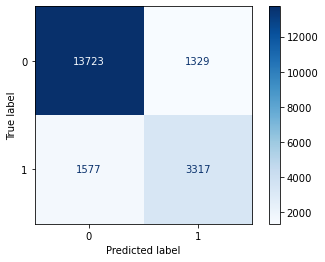

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
m=plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [41]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


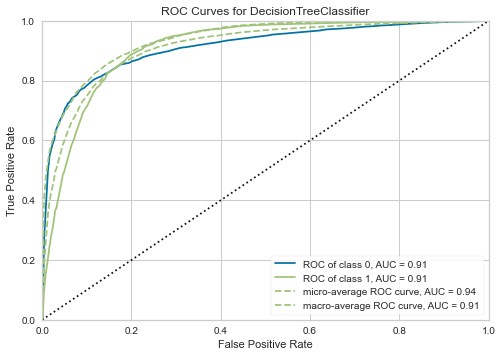

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [45]:
import yellowbrick
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(dt, classes=[0, 1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       

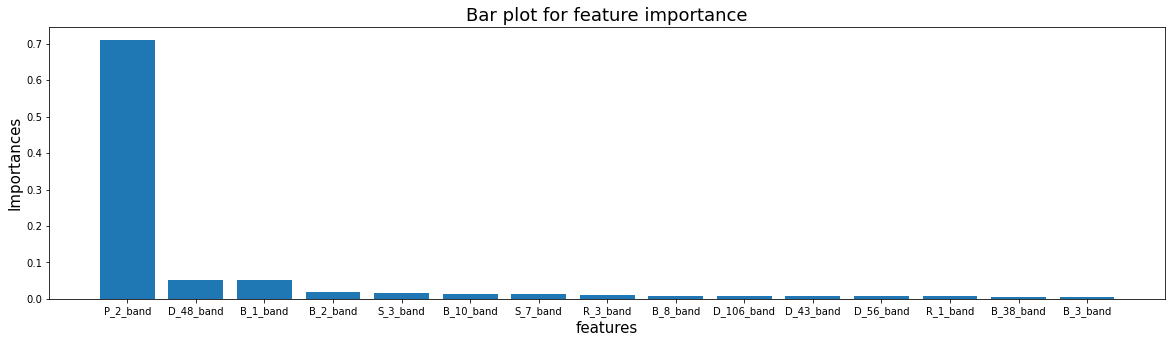

In [32]:
#Gini index used as a critera in decision trees

features = X_train.columns.tolist()
importances_dt = dt.feature_importances_

df_feat = pd.DataFrame({"features":features,
                  "Importances":importances_dt})
df_sorted= df_feat.sort_values("Importances",ascending=False)
df_sorted=df_sorted[0:15]

plt.figure(figsize=(20,5))

plt.bar('features', 'Importances',data=df_sorted)
plt.xlabel("features", size=15)
plt.ylabel("Importances", size=15)
plt.title("Bar plot for feature importance", size=18)
plt.show()



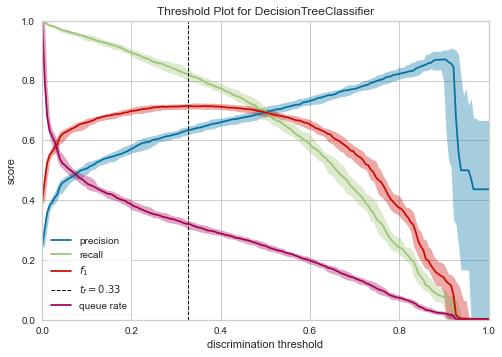

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [46]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import DiscriminationThreshold


visualizer = DiscriminationThreshold(dt)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [14]:
test_y_num=np.array(y_test)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(dt.predict_proba(X_test)[:,1],columns=['prediction'])

In [15]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8098785157967304
Top 4% capture 0.3806702084184716
Final eval metric 0.595274362107601


In [11]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d